# 주식 예측에 도전해 보자
---------

## STEP 1 : 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
# [[YOUR CODE]]

ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

## STEP 2 : 각종 전처리 수행

In [2]:
# 결측치 처리
ts=ts.interpolate(method='time')# [[YOUR CODE]]

ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [3]:
# 로그 변환
ts_log = np.log(ts)# [[YOUR CODE]]

## STEP 3 : 시계열 안정성 분석

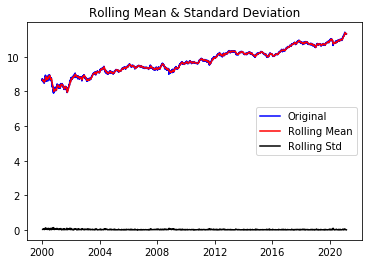

NameError: name 'augmented_dickey_fuller_test' is not defined

In [8]:
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller

# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()# [[YOUR CODE]]

In [44]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성

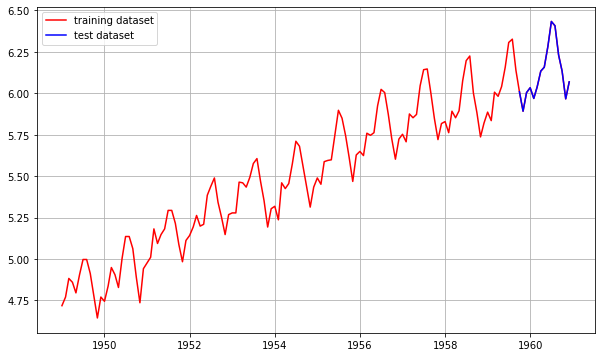

In [45]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
# [[YOUR CODE]]

## STEP 5 : 적정 ARIMA 모수 찾기

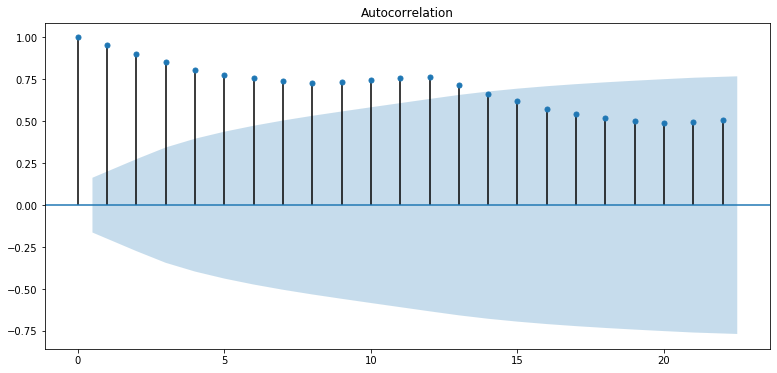

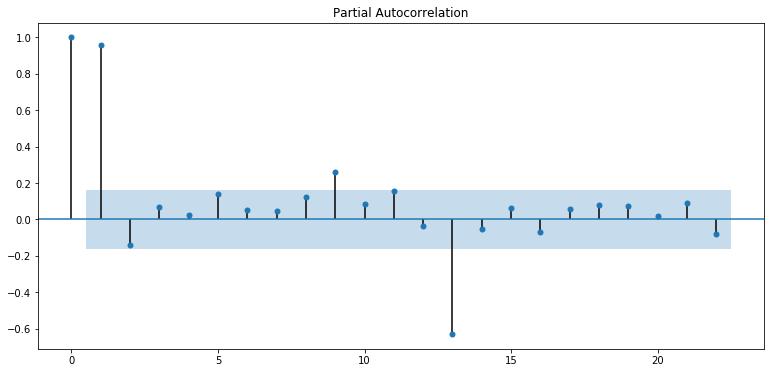

In [46]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


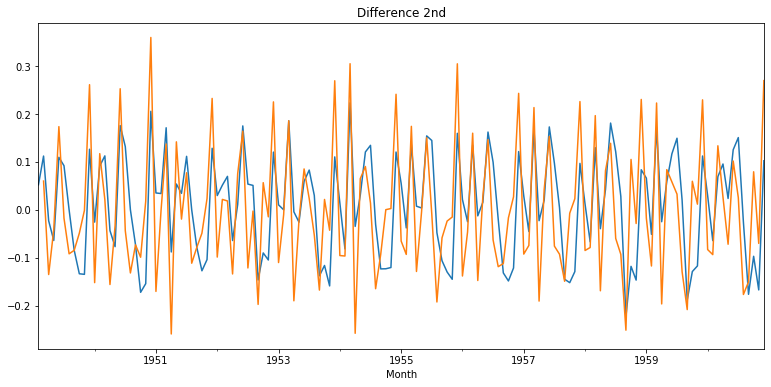

In [47]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')# [[YOUR CODE]]

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트

In [48]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())# [[YOUR CODE]]

                             ARIMA Model Results                              
Dep. Variable:           D.Passengers   No. Observations:                  128
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 108.023
Method:                       css-mle   S.D. of innovations              0.104
Date:                Tue, 02 Mar 2021   AIC                           -210.046
Time:                        22:38:37   BIC                           -201.490
Sample:                    02-01-1949   HQIC                          -206.570
                         - 09-01-1959                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0108      0.011      0.972      0.331      -0.011       0.033
ar.L1.D.Passengers     0.1754      0.088      1.994      0.046       0.003       0.348
                    

/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


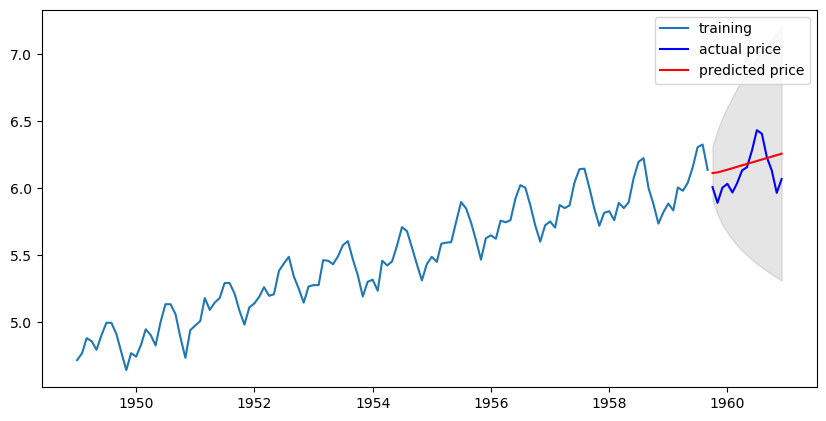

In [49]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf# [[YOUR CODE]]

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드# [[YOUR CODE]]

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()# [[YOUR CODE]]

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))# [[YOUR CODE]]
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))# [[YOUR CODE]]
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5409.550148511177
MAE:  63.13692396363584
RMSE:  73.5496441086643
MAPE: 14.08%


## STEP 7 : 다른 주식 종목 예측해 보기

### NETFLIX

In [51]:
# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/NFLX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
# [[YOUR CODE]]

ts.head()

Date
2019-03-04    351.040009
2019-03-05    354.299988
2019-03-06    359.609985
2019-03-07    352.600006
2019-03-08    349.600006
Name: Close, dtype: float64

In [52]:
# 결측치 처리
ts=ts.interpolate(method='time')# [[YOUR CODE]]

ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [53]:
# 로그 변환
ts_log = np.log(ts)# [[YOUR CODE]]

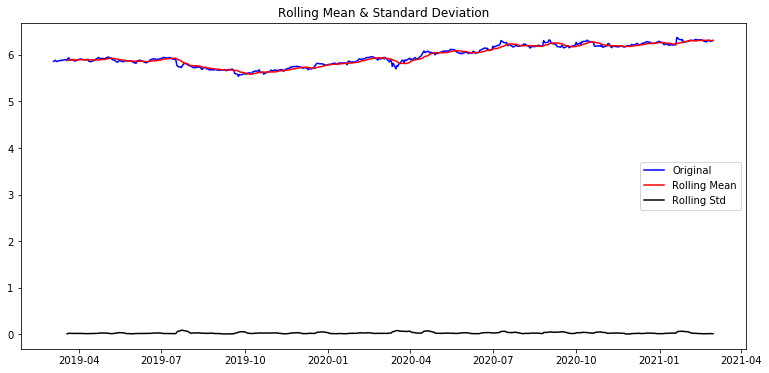

Results of Dickey-Fuller Test:
Test Statistic                  -0.212727
p-value                          0.936987
#Lags Used                      15.000000
Number of Observations Used    487.000000
Critical Value (1%)             -3.443849
Critical Value (5%)             -2.867493
Critical Value (10%)            -2.569941
dtype: float64


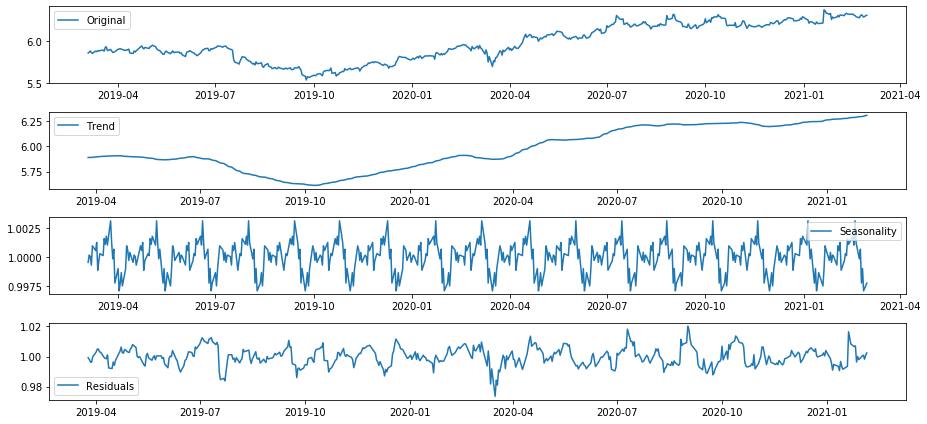

In [54]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()# [[YOUR CODE]]

In [55]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -7.035168e+00
p-value                        6.042431e-10
#Lags Used                     1.800000e+01
Number of Observations Used    4.540000e+02
Critical Value (1%)           -3.444836e+00
Critical Value (5%)           -2.867927e+00
Critical Value (10%)          -2.570172e+00
dtype: float64


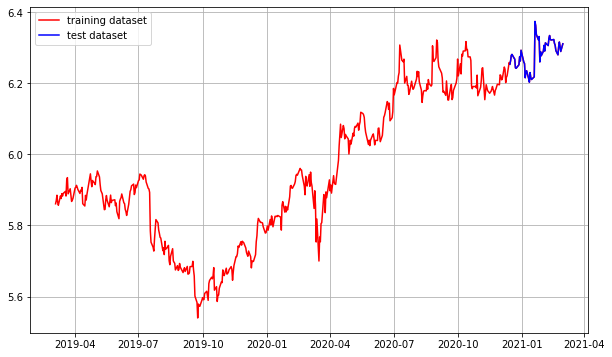

In [56]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
# [[YOUR CODE]]

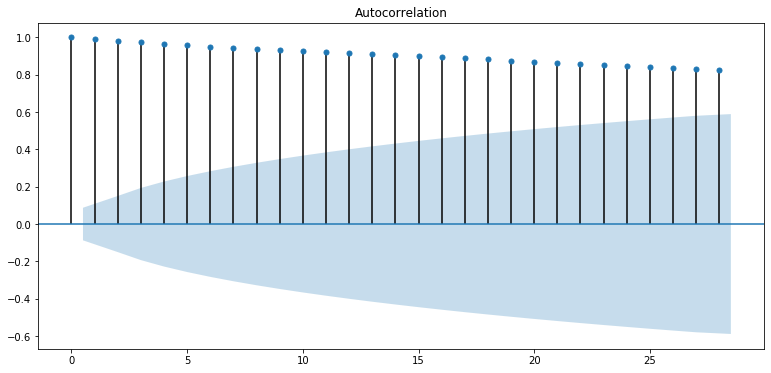

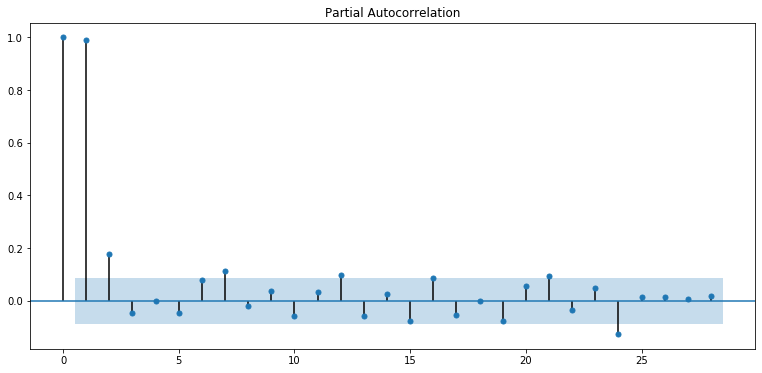

In [57]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -6.665045e+00
p-value                        4.740950e-09
#Lags Used                     1.400000e+01
Number of Observations Used    4.870000e+02
Critical Value (1%)           -3.443849e+00
Critical Value (5%)           -2.867493e+00
Critical Value (10%)          -2.569941e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.047692e+01
p-value                        1.242160e-18
#Lags Used                     1.600000e+01
Number of Observations Used    4.840000e+02
Critical Value (1%)           -3.443933e+00
Critical Value (5%)           -2.867530e+00
Critical Value (10%)          -2.569961e+00
dtype: float64


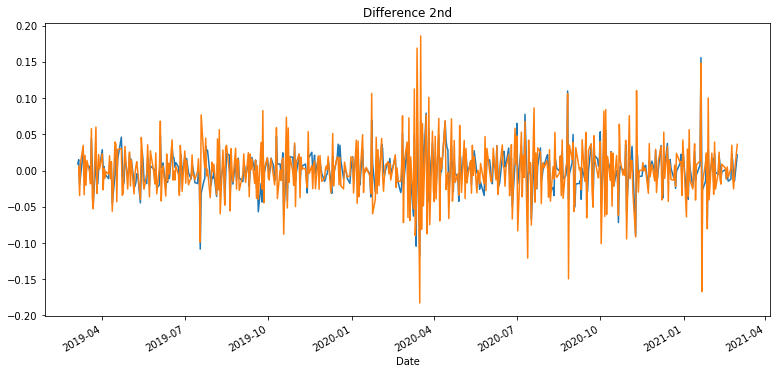

In [58]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')# [[YOUR CODE]]

augmented_dickey_fuller_test(diff_2)

In [59]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())# [[YOUR CODE]]

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  451
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1016.940
Method:                       css-mle   S.D. of innovations              0.025
Date:                Tue, 02 Mar 2021   AIC                          -2027.881
Time:                        22:43:49   BIC                          -2015.546
Sample:                             1   HQIC                         -2023.020
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      0.856      0.392      -0.001       0.003
ar.L1.D.Close    -0.1810      0.046     -3.904      0.000      -0.272      -0.090
                                    Root

/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


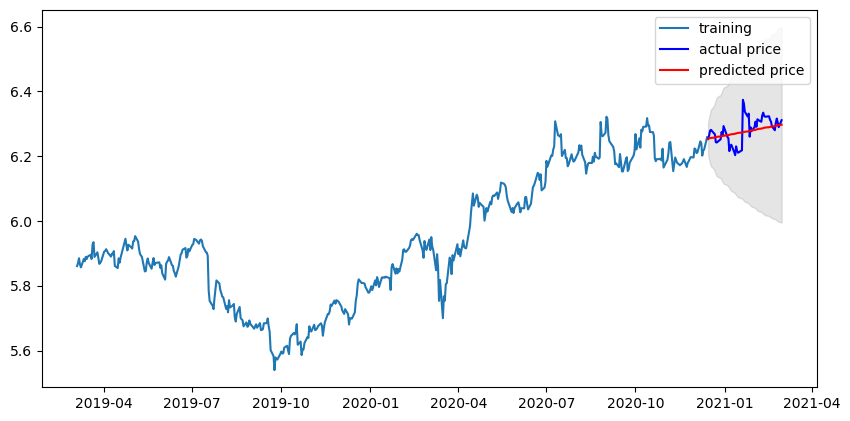

In [60]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf# [[YOUR CODE]]

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드# [[YOUR CODE]]

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()# [[YOUR CODE]]

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))# [[YOUR CODE]]
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))# [[YOUR CODE]]
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  374.2439775263472
MAE:  15.034456653879515
RMSE:  19.345386466192583
MAPE: 2.80%


### Google

In [62]:
# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
# [[YOUR CODE]]

ts.head()

Date
2016-03-02    718.849976
2016-03-03    712.419983
2016-03-04    710.890015
2016-03-07    695.159973
2016-03-08    693.969971
Name: Close, dtype: float64

In [63]:
# 결측치 처리
ts=ts.interpolate(method='time')# [[YOUR CODE]]

ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [64]:
# 로그 변환
ts_log = np.log(ts)# [[YOUR CODE]]

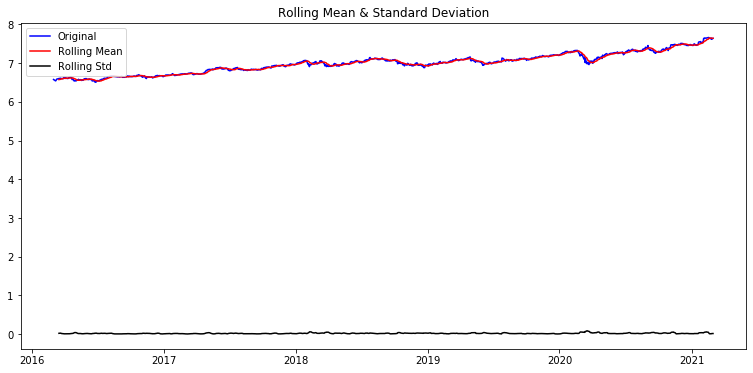

Results of Dickey-Fuller Test:
Test Statistic                   -0.129783
p-value                           0.946390
#Lags Used                        9.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004
dtype: float64


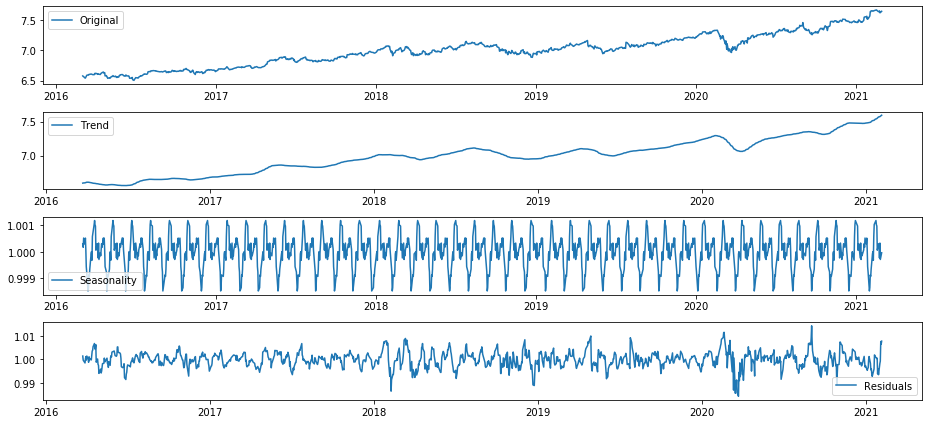

In [65]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()# [[YOUR CODE]]

In [66]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -1.041971e+01
p-value                        1.717296e-18
#Lags Used                     1.900000e+01
Number of Observations Used    1.208000e+03
Critical Value (1%)           -3.435775e+00
Critical Value (5%)           -2.863936e+00
Critical Value (10%)          -2.568045e+00
dtype: float64


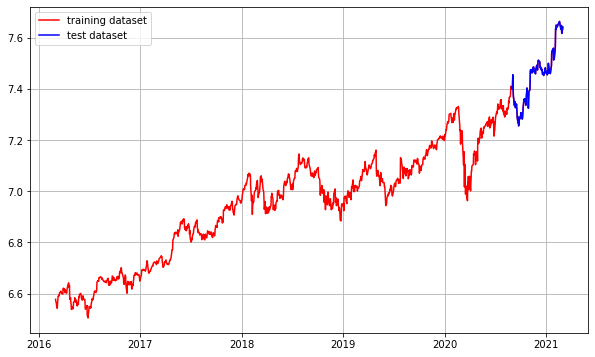

In [67]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
# [[YOUR CODE]]

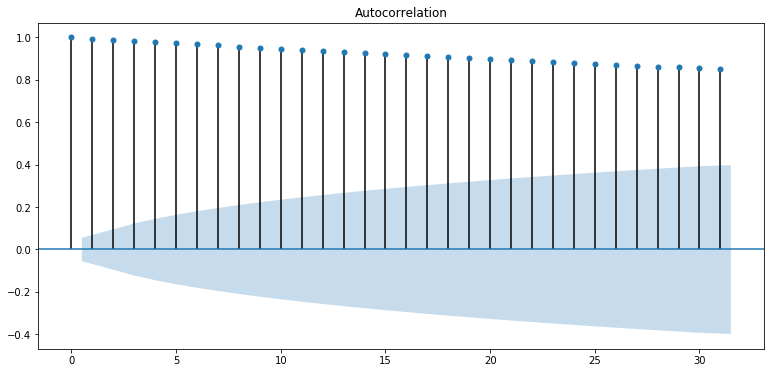

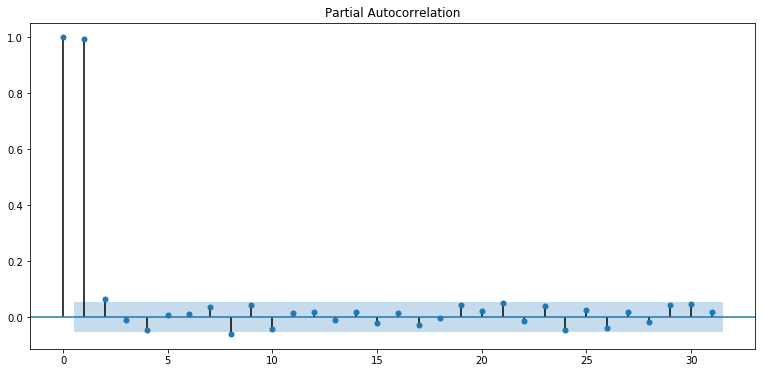

In [68]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -1.163474e+01
p-value                        2.218750e-21
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.193455e+01
p-value                        4.695735e-22
#Lags Used                     2.300000e+01
Number of Observations Used    1.232000e+03
Critical Value (1%)           -3.435669e+00
Critical Value (5%)           -2.863889e+00
Critical Value (10%)          -2.568021e+00
dtype: float64


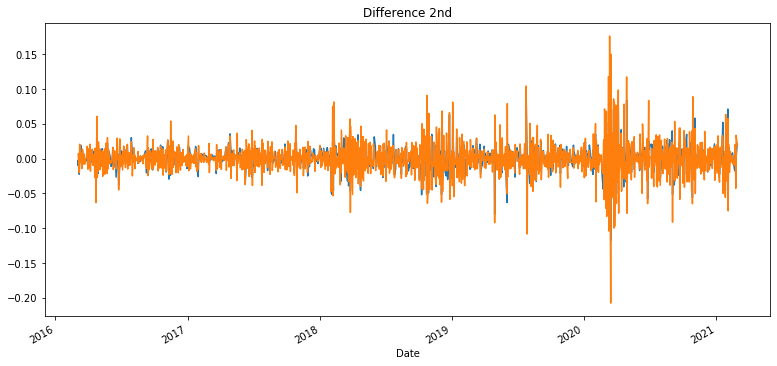

In [69]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')# [[YOUR CODE]]

augmented_dickey_fuller_test(diff_2)

In [70]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())# [[YOUR CODE]]

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3060.171
Method:                       css-mle   S.D. of innovations              0.016
Date:                Tue, 02 Mar 2021   AIC                          -6114.342
Time:                        22:47:46   BIC                          -6099.249
Sample:                             1   HQIC                         -6108.640
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      1.738      0.082   -9.31e-05       0.002
ar.L1.D.Close    -0.1469      0.029     -4.993      0.000      -0.205      -0.089
                                    Root

/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


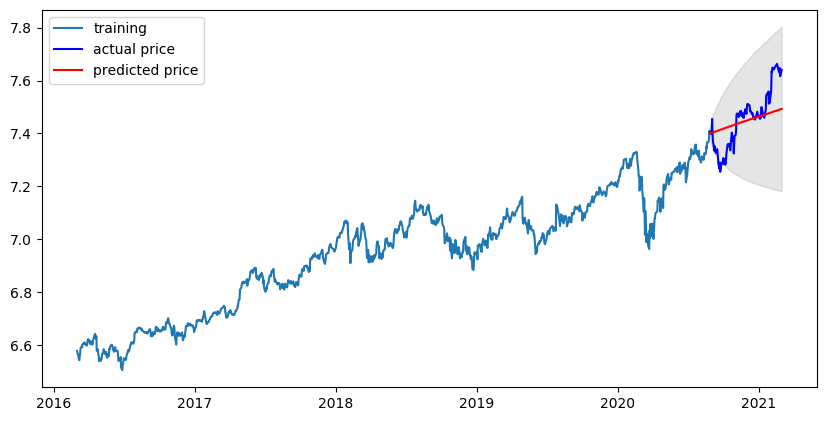

In [71]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf# [[YOUR CODE]]

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드# [[YOUR CODE]]

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()# [[YOUR CODE]]

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))# [[YOUR CODE]]
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))# [[YOUR CODE]]
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  23289.501646122288
MAE:  118.0658049018785
RMSE:  152.6089828487245
MAPE: 6.73%


### Microsoft

In [73]:
# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/MSFT.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
# [[YOUR CODE]]

ts.head()

Date
2016-03-02    52.950001
2016-03-03    52.349998
2016-03-04    52.029999
2016-03-07    51.029999
2016-03-08    51.650002
Name: Close, dtype: float64

In [74]:
# 결측치 처리
ts=ts.interpolate(method='time')# [[YOUR CODE]]

ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [75]:
# 로그 변환
ts_log = np.log(ts)# [[YOUR CODE]]

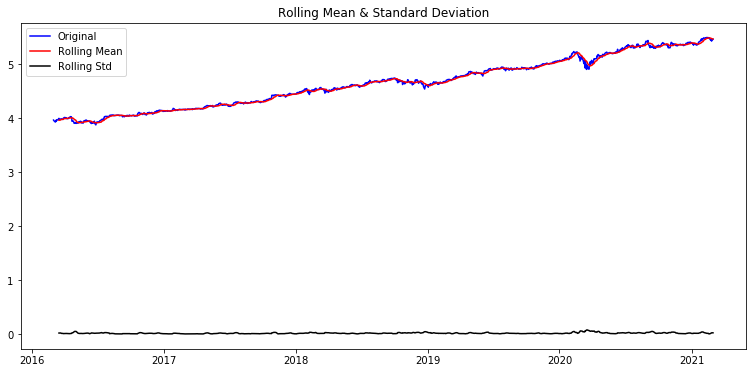

Results of Dickey-Fuller Test:
Test Statistic                    0.026238
p-value                           0.960649
#Lags Used                        9.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004
dtype: float64


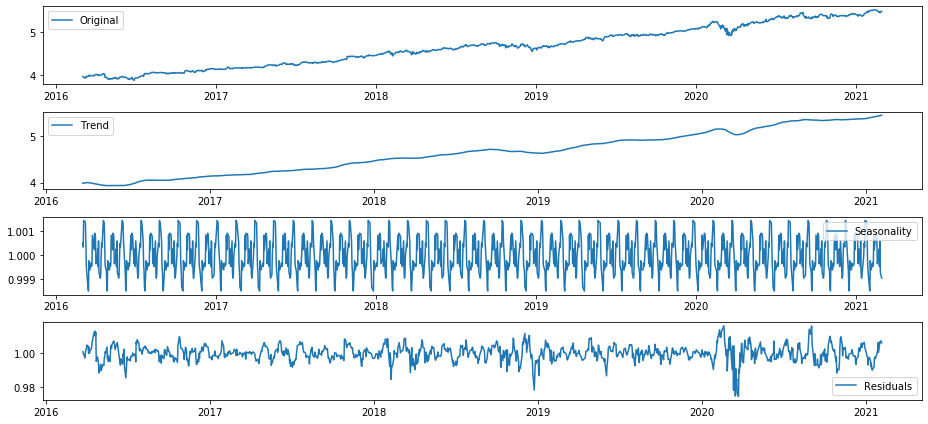

In [76]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()# [[YOUR CODE]]

In [77]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -1.136402e+01
p-value                        9.322312e-21
#Lags Used                     2.100000e+01
Number of Observations Used    1.206000e+03
Critical Value (1%)           -3.435784e+00
Critical Value (5%)           -2.863940e+00
Critical Value (10%)          -2.568048e+00
dtype: float64


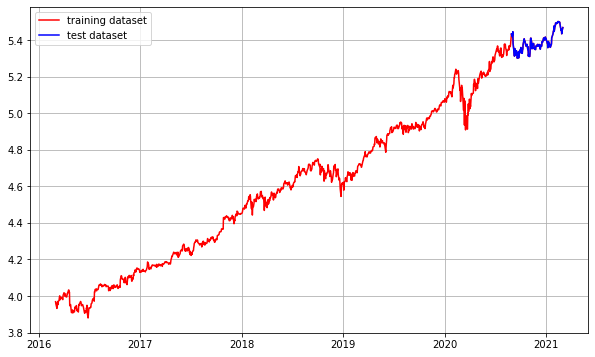

In [78]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
# [[YOUR CODE]]

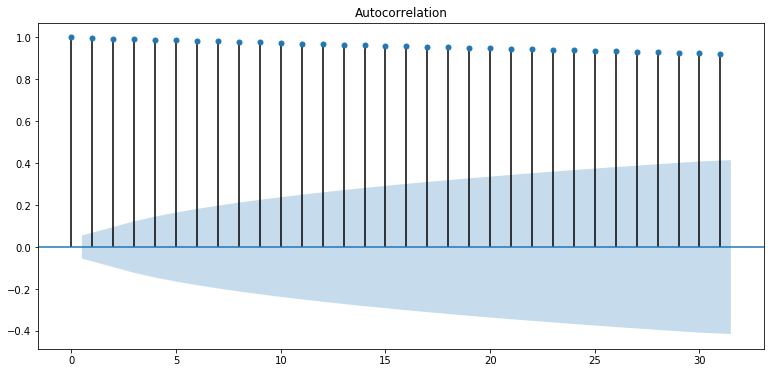

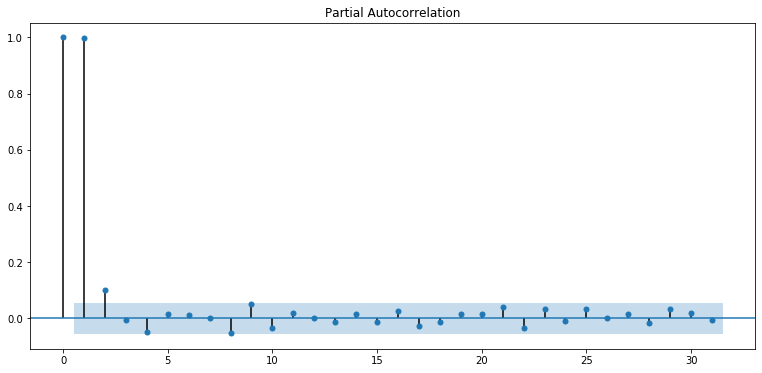

In [79]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -1.243559e+01
p-value                        3.853762e-23
#Lags Used                     8.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.363275e+01
p-value                        1.710912e-25
#Lags Used                     1.900000e+01
Number of Observations Used    1.236000e+03
Critical Value (1%)           -3.435652e+00
Critical Value (5%)           -2.863881e+00
Critical Value (10%)          -2.568016e+00
dtype: float64


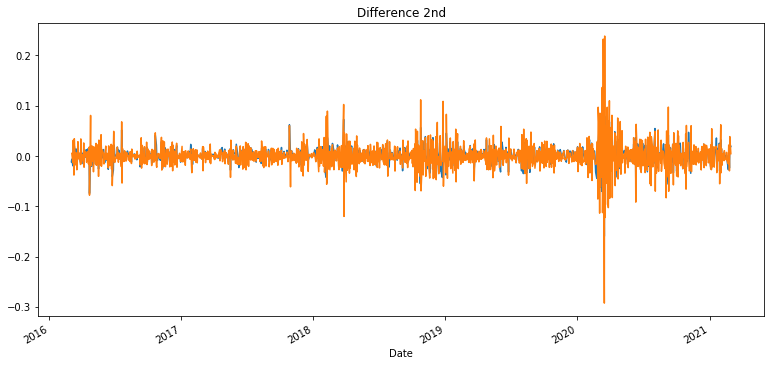

In [80]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')# [[YOUR CODE]]

augmented_dickey_fuller_test(diff_2)

In [81]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())# [[YOUR CODE]]

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3039.371
Method:                       css-mle   S.D. of innovations              0.016
Date:                Tue, 02 Mar 2021   AIC                          -6072.742
Time:                        22:51:20   BIC                          -6057.649
Sample:                             1   HQIC                         -6067.040
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.000      3.397      0.001       0.001       0.002
ar.L1.D.Close    -0.2964      0.028    -10.431      0.000      -0.352      -0.241
                                    Root

/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


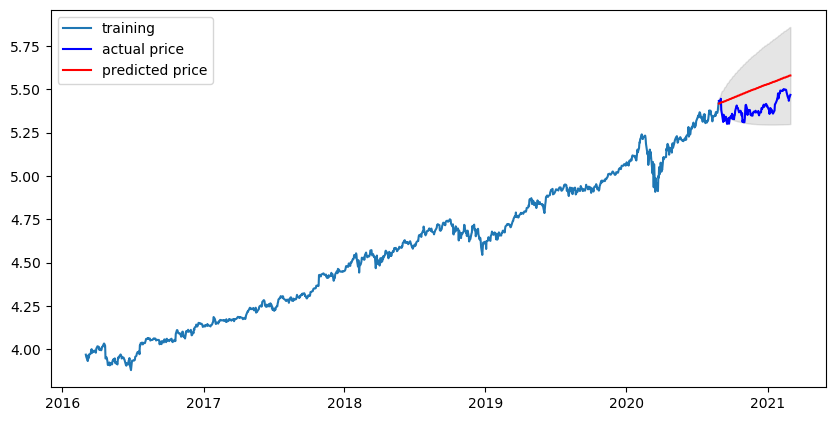

In [82]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf# [[YOUR CODE]]

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드# [[YOUR CODE]]

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()# [[YOUR CODE]]

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))# [[YOUR CODE]]
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))# [[YOUR CODE]]
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  729.2009280837603
MAE:  25.76729789309003
RMSE:  27.00372063408597
MAPE: 11.86%


### SONY

In [84]:
# Time Series 생성
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/SNE.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
# [[YOUR CODE]]

ts.head()

Date
2016-03-02    22.000000
2016-03-03    22.110001
2016-03-04    22.930000
2016-03-07    23.219999
2016-03-08    22.459999
Name: Close, dtype: float64

In [85]:
# 결측치 처리
ts=ts.interpolate(method='time')# [[YOUR CODE]]

ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [86]:
# 로그 변환
ts_log = np.log(ts)# [[YOUR CODE]]

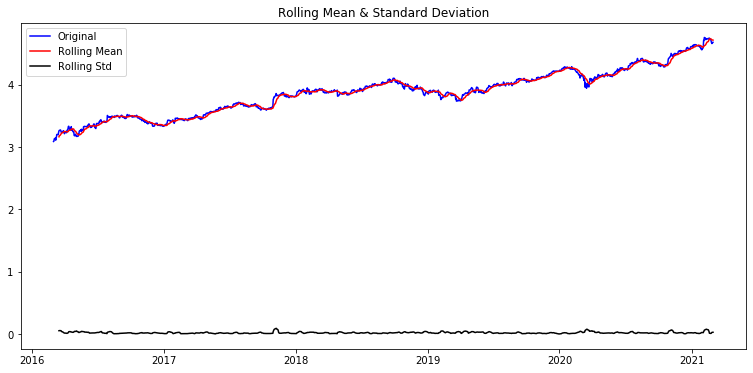

Results of Dickey-Fuller Test:
Test Statistic                   -0.360924
p-value                           0.916421
#Lags Used                        8.000000
Number of Observations Used    1249.000000
Critical Value (1%)              -3.435596
Critical Value (5%)              -2.863857
Critical Value (10%)             -2.568004
dtype: float64


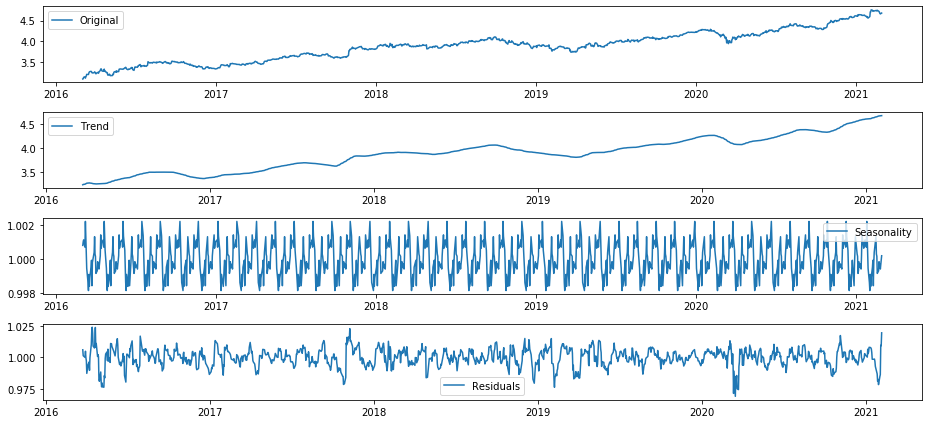

In [87]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()# [[YOUR CODE]]

In [88]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -1.118312e+01
p-value                        2.472575e-20
#Lags Used                     1.800000e+01
Number of Observations Used    1.209000e+03
Critical Value (1%)           -3.435770e+00
Critical Value (5%)           -2.863934e+00
Critical Value (10%)          -2.568044e+00
dtype: float64


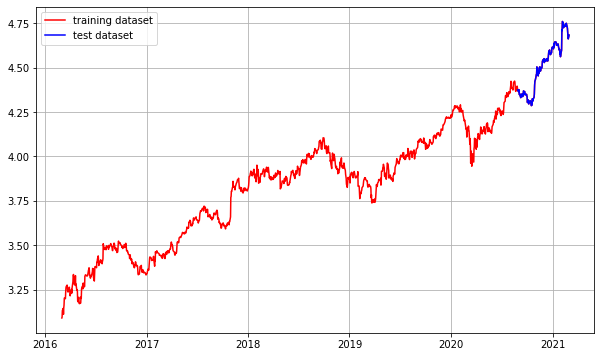

In [89]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
# [[YOUR CODE]]

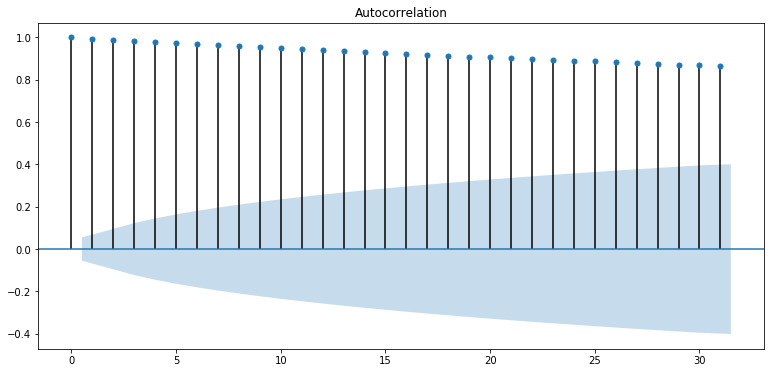

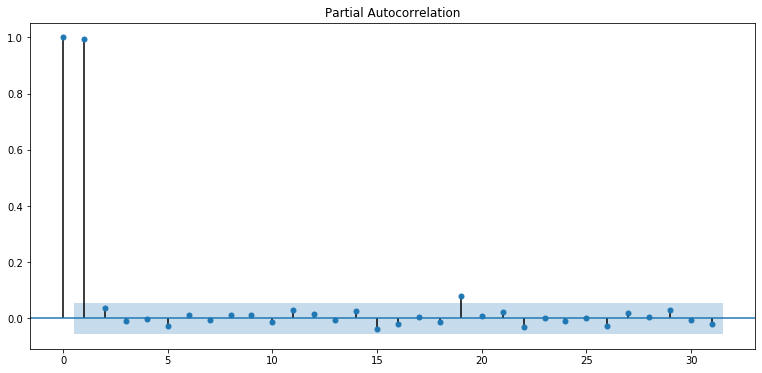

In [90]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()# [[YOUR CODE]]

Results of Dickey-Fuller Test:
Test Statistic                -1.330587e+01
p-value                        6.899666e-25
#Lags Used                     7.000000e+00
Number of Observations Used    1.249000e+03
Critical Value (1%)           -3.435596e+00
Critical Value (5%)           -2.863857e+00
Critical Value (10%)          -2.568004e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.234579e+01
p-value                        5.976906e-23
#Lags Used                     2.300000e+01
Number of Observations Used    1.232000e+03
Critical Value (1%)           -3.435669e+00
Critical Value (5%)           -2.863889e+00
Critical Value (10%)          -2.568021e+00
dtype: float64


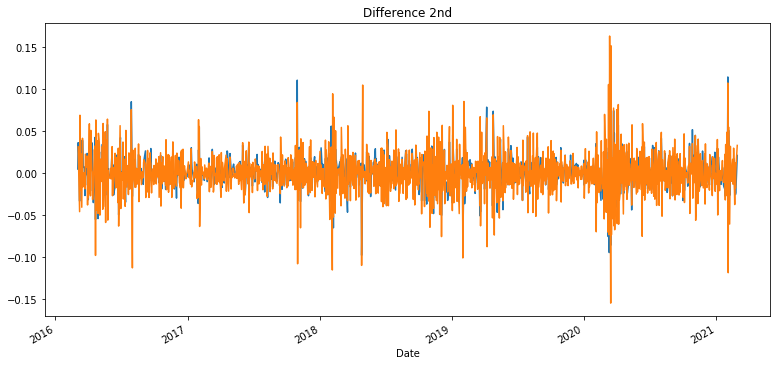

In [91]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')# [[YOUR CODE]]

augmented_dickey_fuller_test(diff_2)

In [92]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())# [[YOUR CODE]]

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1131
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2921.872
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 02 Mar 2021   AIC                          -5837.745
Time:                        22:56:16   BIC                          -5822.652
Sample:                             1   HQIC                         -5832.043
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.000      2.325      0.020       0.000       0.002
ar.L1.D.Close    -0.1017      0.030     -3.438      0.001      -0.160      -0.044
                                    Root

/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


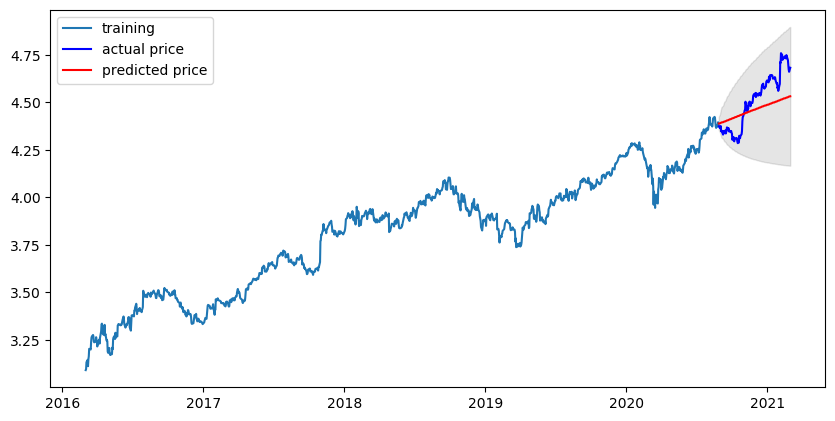

In [93]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf# [[YOUR CODE]]

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드# [[YOUR CODE]]

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()# [[YOUR CODE]]

In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))# [[YOUR CODE]]
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))# [[YOUR CODE]]
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))# [[YOUR CODE]]
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  112.8703871071082
MAE:  8.831529139154123
RMSE:  10.624047585883085
MAPE: 9.26%


## 회고

그대로 따라가면 되는거라 생각보다 괜찮았다.    
하지만 통계는 처음 만나는거라 개념이 엄청 생소했다.    
특히 ARIMA가 어려웠다.    
다시 한번 봐야겠다.     
그래도 MAPE 10% 미만인 회사들을 3개 뽑아서 기분이 좋다.(NETFLIX, Google, SONY)